In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 150)

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

root = '/content/drive/MyDrive/instacart-data'

In [ ]:
aisles = pd.read_csv(root + '/aisles.csv')
departments = pd.read_csv(root + '/departments.csv')
orders = pd.read_csv(root + '/orders.csv')
order_products_prior = pd.read_csv(root + '/order_products__prior.csv')
order_products_train = pd.read_csv(root + '/order_products__train.csv')
products = pd.read_csv(root + '/products.csv')

In [ ]:
print(aisles.shape)
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
print(departmensts.shape)
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
print(orders.shape)

orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
print(order_products_prior.shape)
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
print(order_products_train.shape)
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
print(products.shape)
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


# Data Merge

For Analysis, I am combining order_products_train and order_products_prior as order_products. Based on order_id, product_id, aisle_id and department_id I will merge those data with order_products and will create one single dataframe.

In [ ]:
order_products = pd.concat([order_products_prior, order_products_train], ignore_index = True)
print(order_products.shape)
# reason for ignore_index is set as true, to get range(total_row) as index. default is false,
# which uses original index for as set in df, we get 0 to #order_products_prior and 0 to #order_products_train. so index as duplicates

(33819106, 4)


In [ ]:
order_products = order_products.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

(33819106, 15)

In [ ]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [ ]:
order_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   product_name            object 
 5   aisle_id                int64  
 6   department_id           int64  
 7   aisle                   object 
 8   department              object 
 9   user_id                 int64  
 10  eval_set                object 
 11  order_number            int64  
 12  order_dow               int64  
 13  order_hour_of_day       int64  
 14  days_since_prior_order  float64
dtypes: float64(1), int64(10), object(4)
memory usage: 3.8+ GB


# Reducing memory usage for faster analysis
orginal data requires 3.8+ gb

In [ ]:
def shrink_memory(df):

  """
    It tries to reduce the memory usage of the dataframe
    Parameters: Dataframe
    Return: Dataframe
    """
  start_mem_usg = df.memory_usage().sum() / 1024**3
  print("Memory usage of orignal data is :", round(start_mem_usg , 2)," GB")
  for col in df.columns:
      if df[col].dtypes in ["int64", "int32", "int16"]:

          cmin = df[col].min()
          cmax = df[col].max()

          if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
              df[col] = df[col].astype(np.int8)

          elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
              df[col] = df[col].astype(np.int16)

          elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
              df[col] = df[col].astype(np.int32)

      if df[col].dtypes in ["float64", "float32"]:

          cmin = df[col].min()
          cmax = df[col].max()

          if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
              df[col] = df[col].astype(np.float16)
          elif cmin > np.finfo(np.float8).min and cmax < np.finfo(np.float8).max:
              df[col] = df[col].astype(np.float8)
          elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
              df[col] = df[col].astype(np.float32)


  print("")
  print("Memory after reduction without loss in precision")
  mem_usg = df.memory_usage().sum() / 1024**3
  print("Memory usage is: ",round(mem_usg , 2)," GB")
  print("This is ",100* round(mem_usg/start_mem_usg , 2),"% of the initial size")

  return df

In [ ]:
order_products = shrink_memory(order_products)

Memory usage of orignal data is : 3.78  GB

Memory after reduction without loss in precision
Memory usage is:  1.73  GB
This is  46.0 % of the initial size


In [ ]:
del products, orders, order_products_prior, order_products_train, aisles, departments, shrink_memory
%whos

Variable         Type             Data/Info
-------------------------------------------
color            _ColorPalette    [(0.12156862745098039, 0.<...>863, 0.8117647058823529)]
drive            module           <module 'google.colab.dri<...>s/google/colab/drive.py'>
matplotlib       module           <module 'matplotlib' from<...>/matplotlib/__init__.py'>
np               module           <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
order_products   DataFrame                  order_id  produ<...>819106 rows x 15 columns]
pd               module           <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
plt              module           <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
root             str              /content/drive/MyDrive/instacart-data
sns              module           <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>


# Analysis


In [ ]:
print(order_products.shape)
order_products.head()


(33819106, 15)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


add_to_cart_order - if a user placed an order of multiple products, it tells order/sequence in which these products were added to final order list

order_number - it belongs to a single user, it tells no.of orders this users has placed till now



In [ ]:
ll = order_products[(order_products['user_id'] == 202279)].reset_index(drop = True)
km = ll[ll['product_name']  == 'Organic Egg Whites'].reset_index(drop = True)
km.head(20)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,104690,33120,2,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,8,6,10,30.0
2,132412,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,6,5,9,30.0
3,2808715,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,5,5,13,9.0
4,2894949,33120,5,0,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,1,5,9,NaN
5,1050357,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,train,9,1,14,30.0


# Aisles

In [ ]:
temp_df = order_products.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()
print(temp_df.shape)
temp_df.head(5)

(134, 3)


,aisle,total,reorders
0,fresh fruits,3792661,2726251
1,fresh vegetables,3568630,2123540
2,packaged vegetables fruits,1843806,1178700
3,yogurt,1507583,1034957
4,packaged cheese,1021462,598280


grouped by aisle column and aggreated as count and sum of reordered values

### Total Orders and Reorders From 25 most Popular Aisles


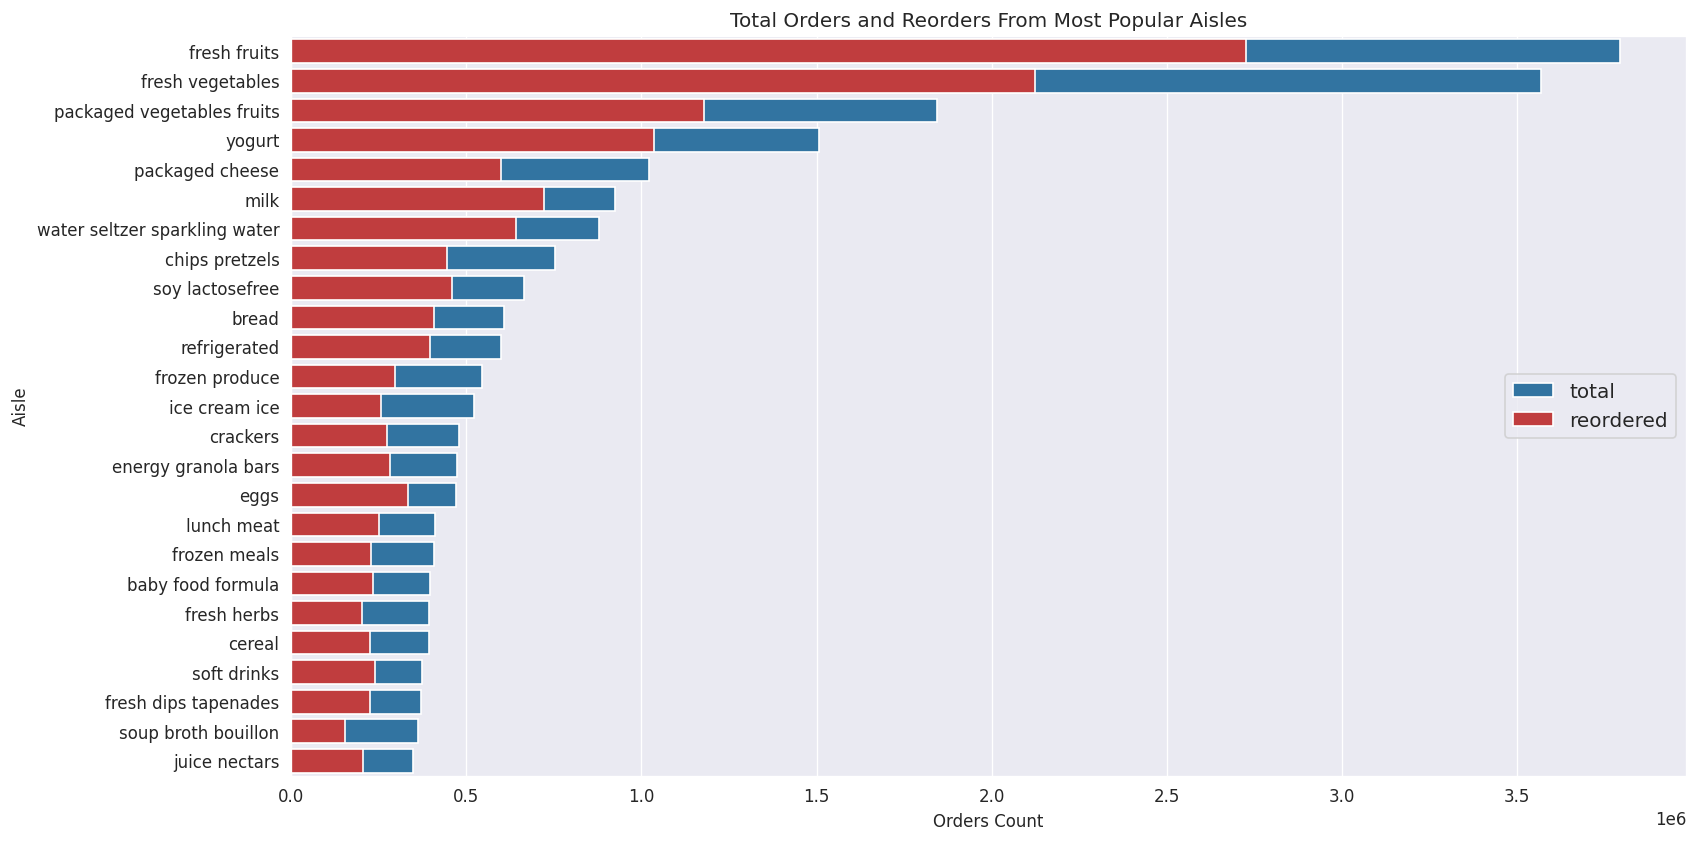

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(y = temp_df.aisle[0:25], x = temp_df.total[0:25], color=color[0], label = "total")
ax = sns.barplot(y = temp_df.aisle[0:25], x = temp_df.reorders[0:25], color=color[3], label = "reordered")
ax.set_ylabel("Aisle")
ax.set_xlabel("Orders Count")
ax.set_title("Total Orders and Reorders From Most Popular Aisles")
ax.legend( loc = 7 , prop={'size': 12})
plt.show()

In [ ]:
temp_df["reorder_ratio"] = temp_df.reorders/temp_df.total
temp_df = temp_df.sort_values("reorder_ratio", ascending=False).reset_index()
# added a new column reorder ratio

### 25 Aisles with Highest Reorder Ratio


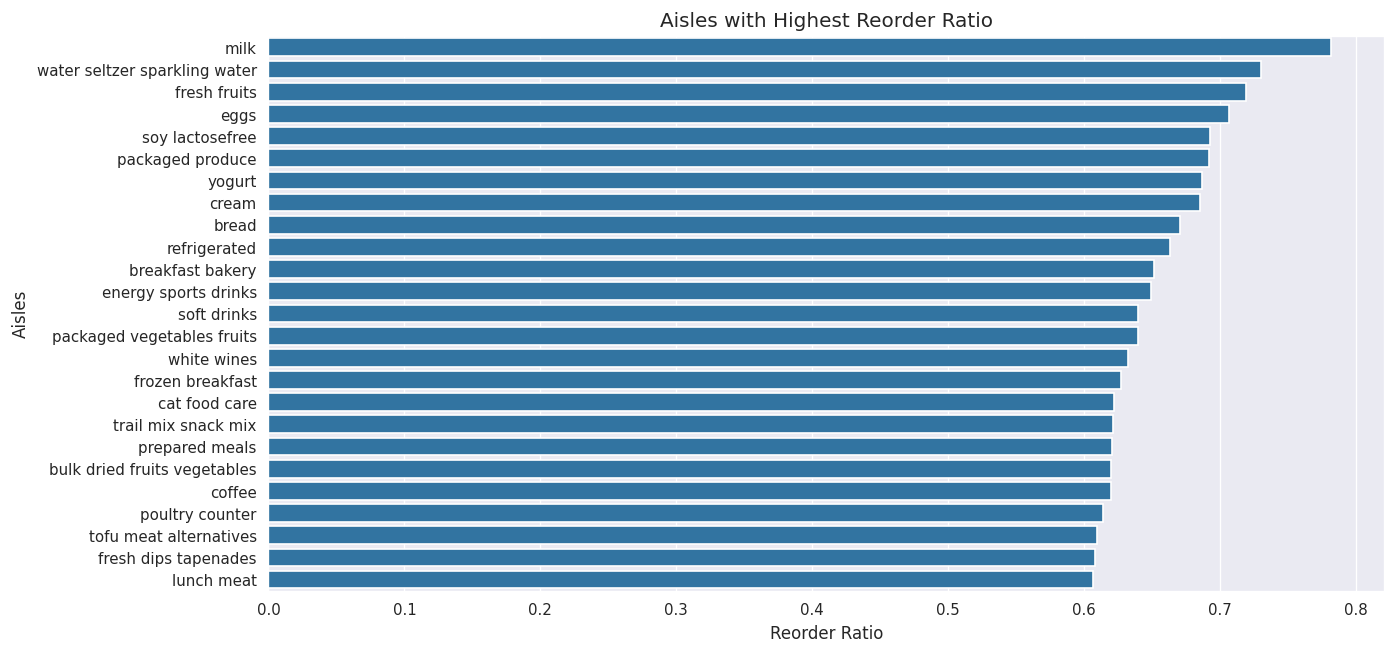

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.barplot(y = temp_df.aisle[0:25], x = temp_df.reorder_ratio[0:25], color=color[0])
ax.set_ylabel("Aisles")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Aisles with Highest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 8)
plt.show()

### 25 Aisles with Lowest Reorder Ratio

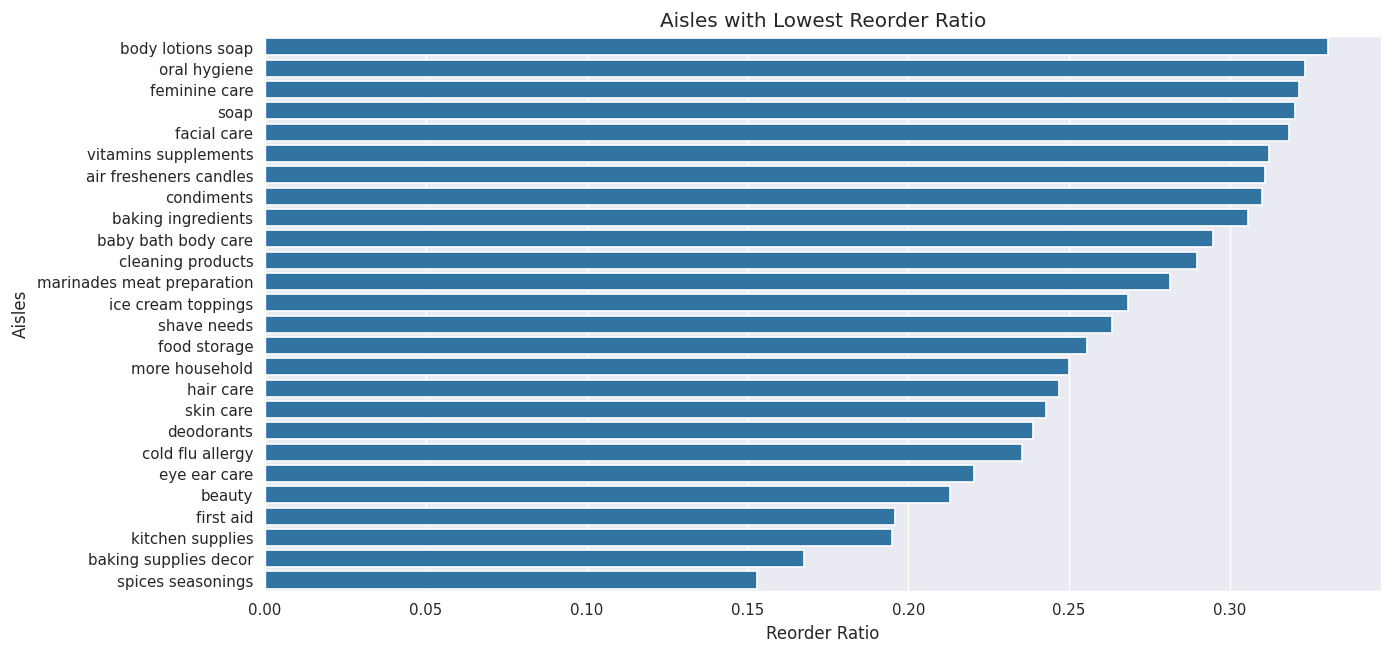

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.barplot(y = temp_df.aisle[-26:], x = temp_df.reorder_ratio[-26:], color=color[0])
ax.set_ylabel("Aisles")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Aisles with Lowest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 8)
plt.show()

## Departments(21)

In [ ]:
dep_df = order_products.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
dep_df = dep_df.sort_values('total', ascending=False).reset_index()

#### Total Orders and Reorders From Departments


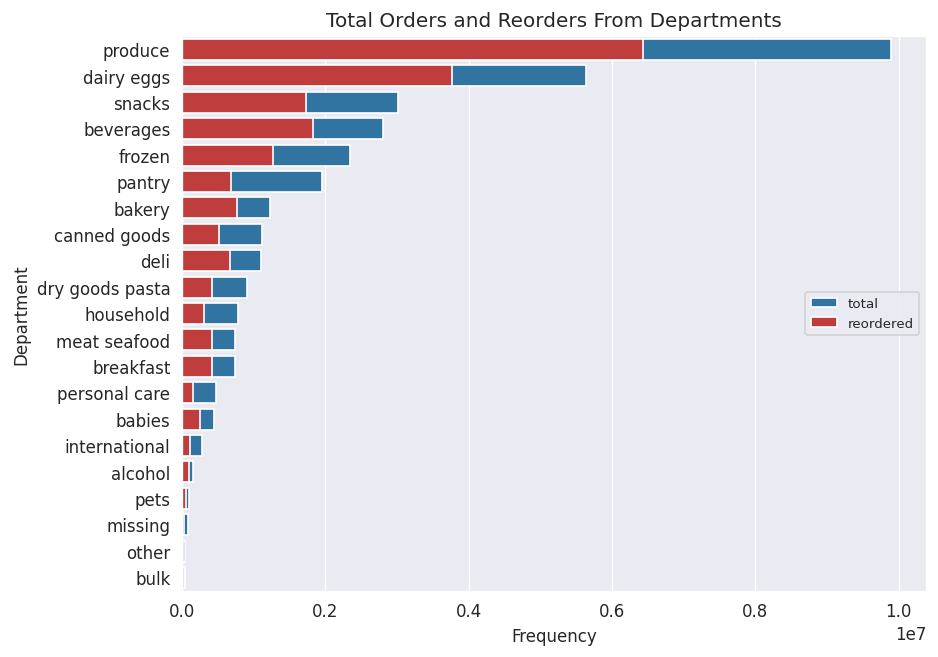

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.barplot(y = dep_df.department, x = dep_df["total"], color=color[0], label = "total")
ax = sns.barplot(y = dep_df.department, x = dep_df["reorders"], color=color[3], label = "reordered")
ax.set_ylabel("Department")
ax.set_xlabel("Frequency")
ax.legend(loc = 7, prop={'size': 8})
ax.set_title("Total Orders and Reorders From Departments")
plt.show()

In [ ]:
dep_df["reorder_ratio"] = temp_df.reorders/temp_df.total
dep_df = dep_df.sort_values("reorder_ratio", ascending=False).reset_index()

#### Departments with Highest Reorder Ratio


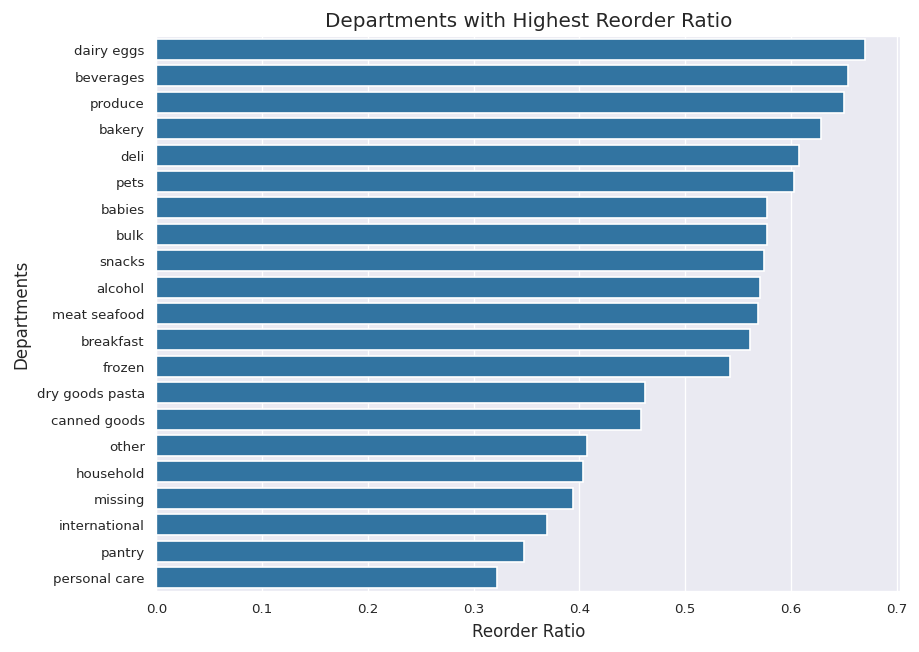

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.barplot(y = dep_df.department, x = dep_df.reorder_ratio, color=color[0])
ax.set_ylabel("Departments")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Departments with Highest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 8)
plt.show()

## Products(#49688 )

In [ ]:
prod_df = order_products.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
prod_df = prod_df.sort_values('total', ascending=False).reset_index()

#### Most Popular Products


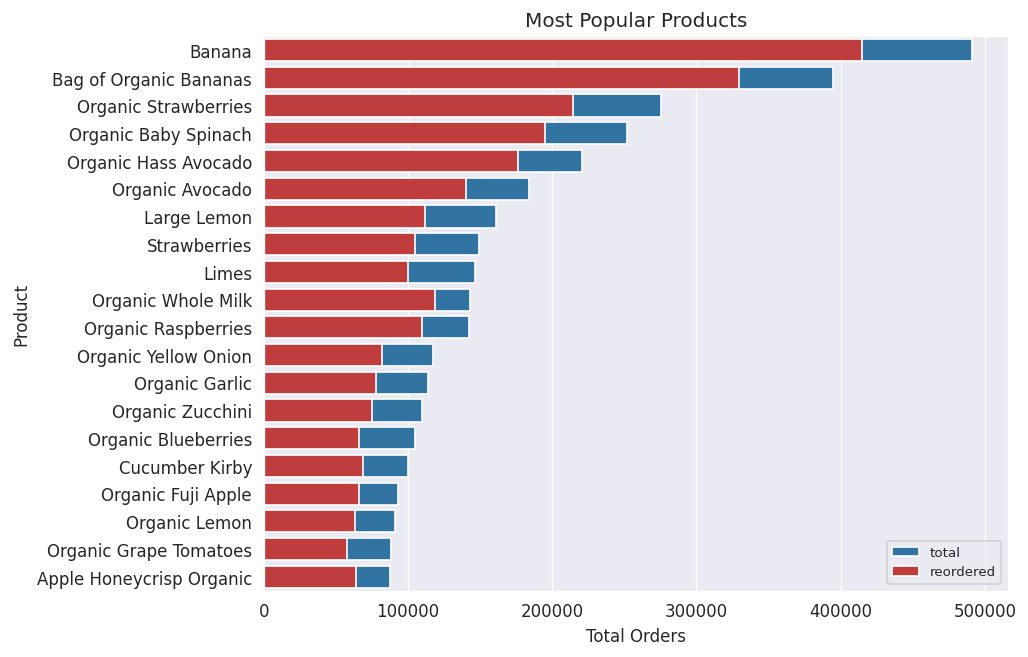

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.barplot(y = prod_df.product_name[0:20], x = prod_df.total[0:20], color=color[0], label = "total")
ax = sns.barplot(y = prod_df.product_name[0:20], x = prod_df.reorders[0:20], color=color[3], label = "reordered")
ax.set_ylabel("Product")
ax.set_xlabel("Total Orders")
ax.set_title("Most Popular Products")
ax.legend(loc = 4, prop={'size': 8})
plt.show()

Below, gives the top products sorted by their reorder ratio

In [ ]:
prod_df["reorder_ratio"] = prod_df.reorders/prod_df.total
prod_df.sort_values("reorder_ratio", ascending=False).head(10)

,product_name,total,reorders,reorder_ratio
23853,Raw Veggie Wrappers,69,65,0.942029
21388,Serenity Ultimate Extrema Overnight Pads,90,84,0.933333
40147,Orange Energy Shots,13,12,0.923077
20296,Chocolate Love Bar,102,94,0.921569
30746,Soy Powder Infant Formula,35,32,0.914286
28078,Simply Sleep Nighttime Sleep Aid,45,41,0.911111
35213,"Energy Shot, Grape Flavor",22,20,0.909091
32316,Russian River Valley Reserve Pinot Noir,30,27,0.900000
23918,Bars Peanut Butter,69,62,0.898551
24218,Soy Crisps Lightly Salted,67,60,0.895522


## Product User

To calculate total unique users for each product

In [ ]:
product_unique_users = order_products.groupby('product_name')['user_id'].nunique().reset_index().rename(columns={'user_id':'total_unq_users'})
product_unique_users.sort_values('total_unq_users', ascending = False).reset_index(drop = True).head(10)

,product_name,total_unq_users
0,Banana,76125
1,Bag of Organic Bananas,65655
2,Organic Strawberries,61129
3,Organic Baby Spinach,56766
4,Large Lemon,48614
5,Limes,46658
6,Strawberries,44857
7,Organic Hass Avocado,44704
8,Organic Avocado,43954
9,Organic Blueberries,38720


In [ ]:
product_unique_users = product_unique_users.merge(prod_df, on='product_name', how='left')
product_unique_users.sort_values("reorder_ratio", ascending=False).reset_index(drop = True).head(7)

,product_name,total_unq_users,total,reorders,reorder_ratio
0,Raw Veggie Wrappers,4,69,65,0.942029
1,Serenity Ultimate Extrema Overnight Pads,6,90,84,0.933333
2,Orange Energy Shots,1,13,12,0.923077
3,Chocolate Love Bar,8,102,94,0.921569
4,Soy Powder Infant Formula,3,35,32,0.914286
5,Simply Sleep Nighttime Sleep Aid,4,45,41,0.911111
6,"Energy Shot, Grape Flavor",2,22,20,0.909091


#### Cumulative Sum of Unique Users Per Product


In [ ]:
temp_df = product_unique_users.sort_values("total_unq_users", ascending=False)
temp_df['cum_users'] = temp_df['total_unq_users'].cumsum()
temp_df = temp_df.reset_index(drop=True)
temp_df.head()

,product_name,total_unq_users,total,reorders,reorder_ratio,cum_users
0,Banana,76125,491291,415166,0.845051,76125
1,Bag of Organic Bananas,65655,394930,329275,0.833755,141780
2,Organic Strawberries,61129,275577,214448,0.778178,202909
3,Organic Baby Spinach,56766,251705,194939,0.774474,259675
4,Large Lemon,48614,160792,112178,0.697659,308289


In [ ]:
temp_df.tail()

,product_name,total_users,total,reorders,reorder_ratio,cum_users
49680,"Organic Kiwi, Banana, & Apple with Super Grain...",1,2,1,0.5,13863742
49681,Piquillo & Jalapeno Bruschetta,1,1,0,0.0,13863743
49682,Sugar Leaf Stevia and Raw Cane Sugar,1,1,0,0.0,13863744
49683,Peachtree Schnapps,1,1,0,0.0,13863745
49684,"Flax Oil, Organic, Omega-3, Original Formula",1,1,0,0.0,13863746


In [ ]:
order_products.user_id.nunique()
# total unique users

206209

In [ ]:
# total user 200k, 0.1% ~ 200 and 1% ~ 2k
total_unq = order_products.user_id.nunique()
total_prod = temp_df.shape[0]
prod_users_99 = temp_df[temp_df.total_users > int(0.01*total_unq) ]
prod_users_999 = temp_df[temp_df.total_users > int(0.001*total_unq) ]

print(f"about {100 - int(prod_users_999.shape[0]/total_prod*100)}% products are bought by less than 200 users i.e., ~ 0.1% of total users"   )

about 81% products are bought by less than 200 users i.e., ~ 0.1% of total users


we can focus more on 20% products to cater most of the customers

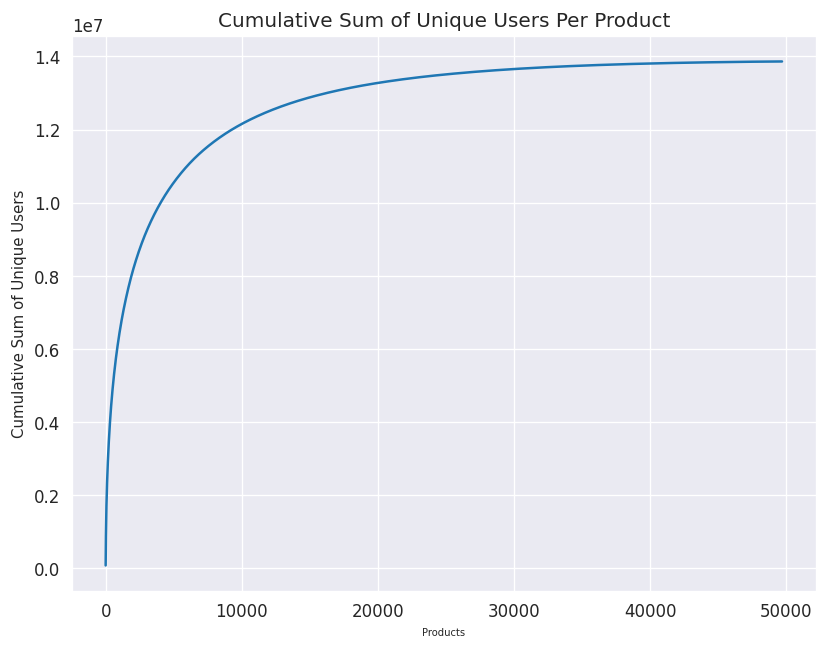

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(x = temp_df.index, y=temp_df.cum_users)
ax.set_xlabel("Products", size = 6)
ax.set_ylabel("Cumulative Sum of Unique Users", size = 9)
ax.set_title("Cumulative Sum of Unique Users Per Product", size = 12)
plt.show()

By a mere 20% total products we can almost cater to 99.9% of our users!!!!

#### Total Product Orders VS Total Unique Product Buyers


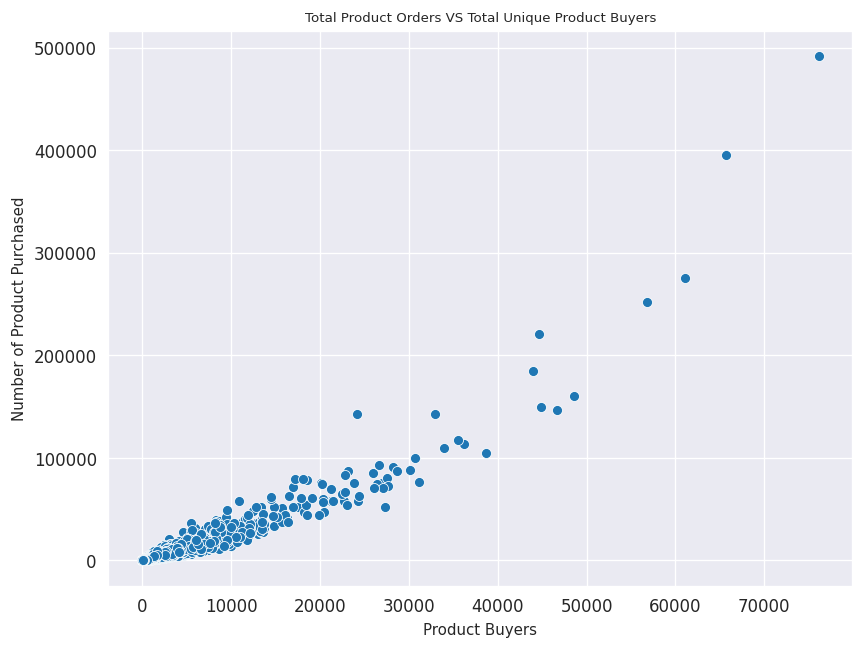

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.scatterplot(y = product_unique_users.total, x = product_unique_users.total_unq_users)
ax.set_xlabel("Product Buyers", size = 9)
ax.set_ylabel("Number of Product Purchased", size = 9)
ax.set_title("Total Product Orders VS Total Unique Product Buyers", size = 8)
plt.show()

#### Reorder Percentage VS Total Orders


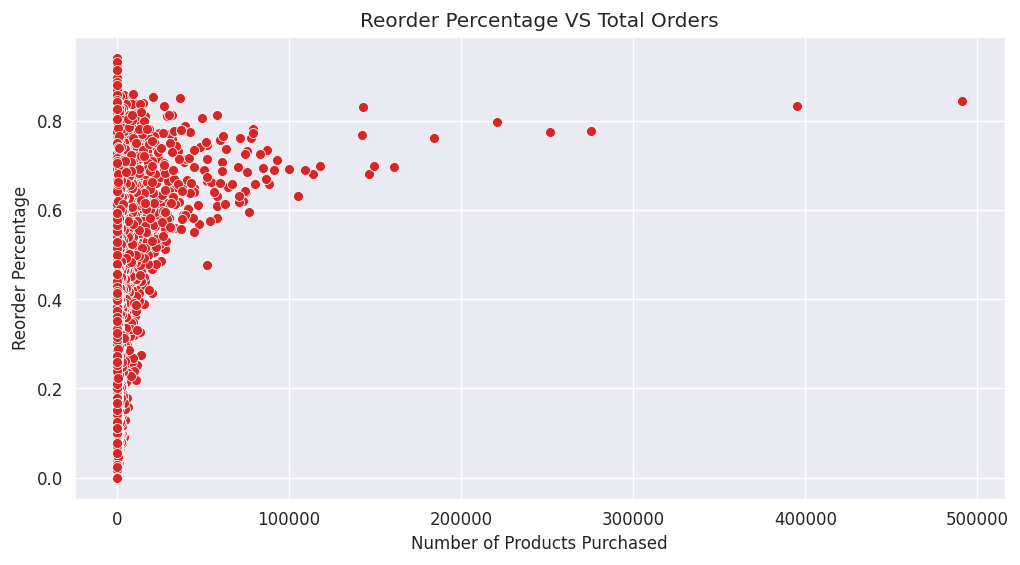

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.scatterplot(x = product_unique_users.total, y = product_unique_users.reorder_ratio, color = color[3])
ax.set_xlabel("Number of Products Purchased")
ax.set_ylabel("Reorder Percentage")
ax.set_title("Reorder Percentage VS Total Orders")
plt.show()

Each scatter point says about a single product, no.of purchases of it and reorder percentage

#### Reorder Percentage VS Total Unique Users


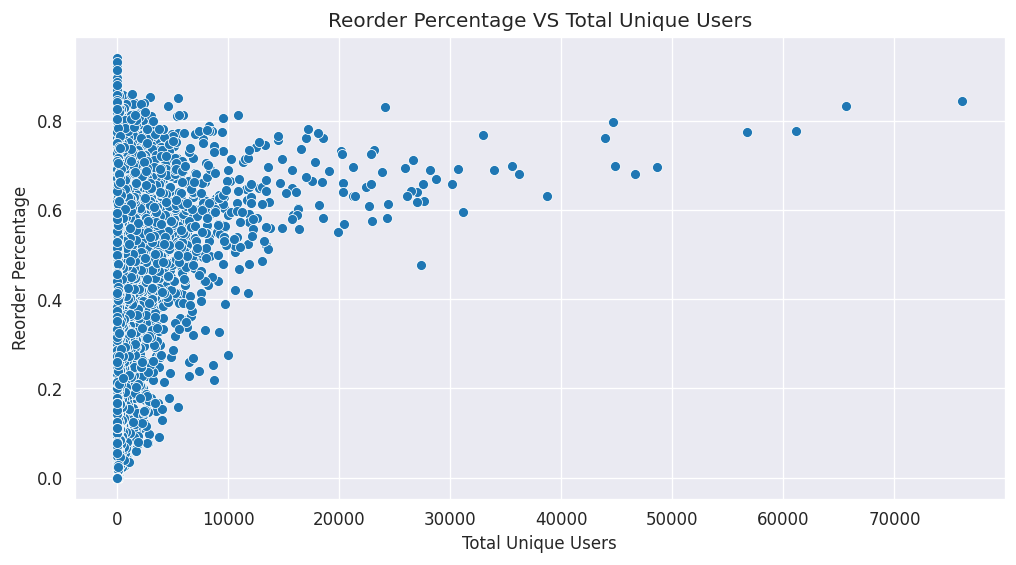

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.scatterplot(x = product_unique_users.total_unq_users, y = product_unique_users.reorder_ratio, color = color[0])
ax.set_xlabel("Total Unique Users")
ax.set_ylabel("Reorder Percentage")
ax.set_title("Reorder Percentage VS Total Unique Users")
plt.show()

#### Organic Vs Inorganic


In [ ]:

product_unique_users.head()

,product_name,total_unq_users,total,reorders,reorder_ratio
0,#2 Coffee Filters,534,799,265,0.331665
1,#2 Cone White Coffee Filters,11,14,3,0.214286
2,#2 Mechanical Pencils,9,9,0,0.000000
3,#4 Natural Brown Coffee Filters,157,247,90,0.364372
4,& Go! Hazelnut Spread + Pretzel Sticks,81,174,93,0.534483


In [ ]:
product_unique_users['Org_Inorg'] = product_unique_users.product_name.str.contains("Organic")
product_unique_users['Org_Inorg'] = np.where( product_unique_users['Org_Inorg'] == True, 'Organic', 'Inorganic' )
# product_unique_users['Org/Inorg'] = product_unique_users['Org/Inorg'].apply( lambda x : 'Organic' if x == True 'Inorganic' )
product_unique_users.head()

,product_name,total_unq_users,total,reorders,reorder_ratio,Org/Inorg,Org_Inorg
0,#2 Coffee Filters,534,799,265,0.331665,Inorganic,Inorganic
1,#2 Cone White Coffee Filters,11,14,3,0.214286,Inorganic,Inorganic
2,#2 Mechanical Pencils,9,9,0,0.000000,Inorganic,Inorganic
3,#4 Natural Brown Coffee Filters,157,247,90,0.364372,Inorganic,Inorganic
4,& Go! Hazelnut Spread + Pretzel Sticks,81,174,93,0.534483,Inorganic,Inorganic


In [ ]:
product_unique_users.Org_Inorg.value_counts()

,count
Org_Inorg,
Inorganic,44650
Organic,5035


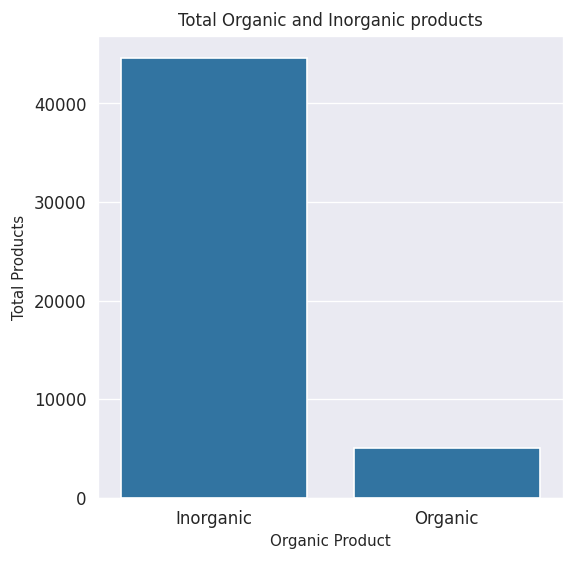

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.barplot(x = product_unique_users.Org_Inorg.value_counts().index,  y = product_unique_users.Org_Inorg.value_counts().values  )
ax.set_xlabel("Organic Product", size = 9)
ax.set_ylabel("Total Products", size = 9)
ax.set_title("Total Organic and Inorganic products", size = 10)
plt.show()

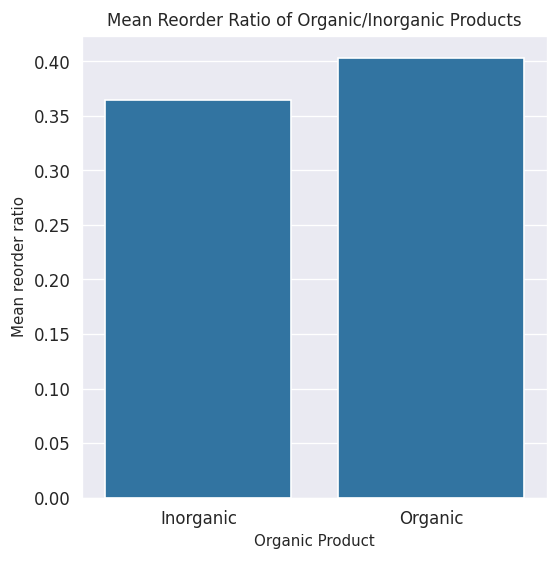

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.barplot(x = product_unique_users.groupby('Org_Inorg')['reorder_ratio'].mean().index, y = product_unique_users.groupby('Org_Inorg')['reorder_ratio'].mean().values)
ax.set_xlabel("Organic Product", size = 9)
ax.set_ylabel("Mean reorder ratio", size = 9)
ax.set_title("Mean Reorder Ratio of Organic/Inorganic Products", size = 10)
plt.show()

#### Add to Cart Order VS Reorder

Explores the relationship between the order in which a product is added to the cart and the likelihood of that product being reordered

In [ ]:
temp_df = order_products.groupby('add_to_cart_order')['reordered'].mean().reset_index()
temp_df.head()

,add_to_cart_order,reordered
0,1,0.679302
1,2,0.677135
2,3,0.658426
3,4,0.637350
4,5,0.617598


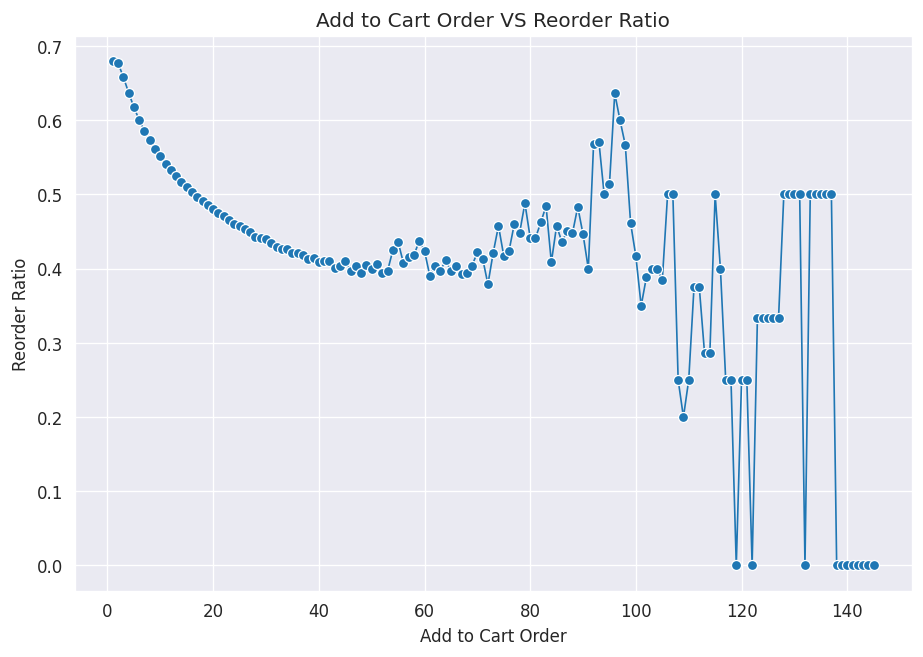

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.lineplot(x=temp_df.add_to_cart_order, y=temp_df.reordered, lw = 1, marker='o')
ax.set_xlabel("Add to Cart Order")
ax.set_ylabel("Reorder Ratio")
ax.set_title("Add to Cart Order VS Reorder Ratio")
plt.show()

items which are added first in the cart are likely to be reordered


#### Most Popular Products on different days


In [ ]:
temp_df = order_products.groupby(['order_dow', 'product_name']).size().reset_index(name='counts')
temp_df = temp_df.sort_values(['order_dow', 'counts'], ascending=[True, False])
temp_df = temp_df.groupby('order_dow').head(5).reset_index(drop = True) # choosing top 5 most sold products on each day


In [ ]:
temp_df

,order_dow,product_name,counts
0,0,Banana,101474
1,0,Bag of Organic Bananas,75052
2,0,Organic Baby Spinach,57556
3,0,Organic Strawberries,56635
4,0,Organic Hass Avocado,45841
5,1,Banana,90750
6,1,Bag of Organic Bananas,72206
7,1,Organic Strawberries,47897
8,1,Organic Baby Spinach,43819
9,1,Organic Hass Avocado,39660


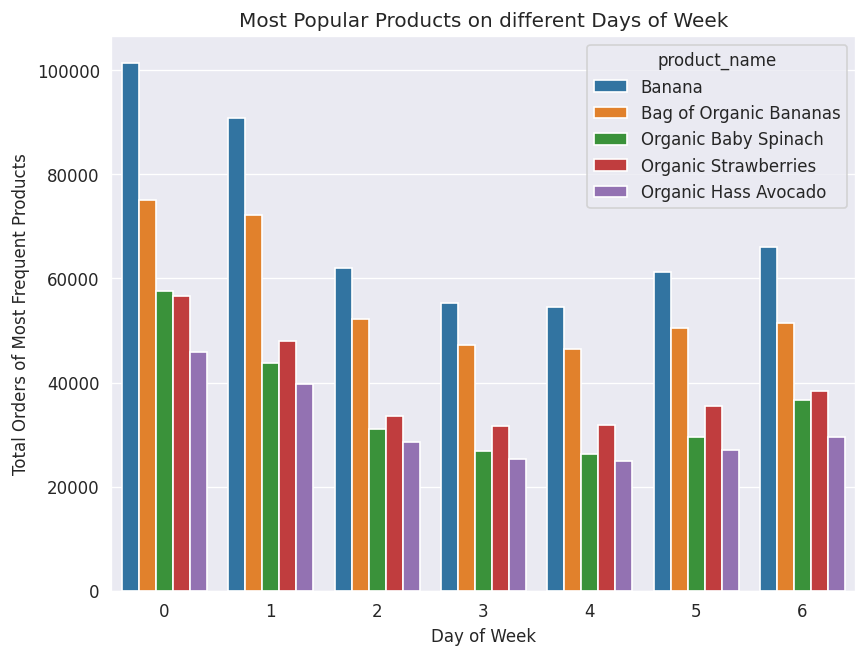

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.barplot(x="order_dow", y="counts", hue="product_name", data=temp_df,  legend=True)
ax.set_xlabel("Day of Week" )
ax.set_ylabel("Total Orders of Most Frequent Products")
ax.set_title("Most Popular Products on different Days of Week", va="baseline", ha="center")
fig.savefig("Most Popular Products on Different Days of Week.png")